# Lecture 20: Unsupervised Learning

COMP 3921F \
Applied Machine Learning \
Mon 4:40 PM - 5:55 PM \
Tue: 5:00 PM - 6:15 PM

Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Apr xx, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 4 still open for submission.
2. Recitation will review Clustering and Principal Components
3. You should continue  to review and refresh yourself on the mathematical prerequisites for applied machine learning from part 1 for Deisenroth, Faisal and Ong, __[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)__.


# Unsupervised Learning

<table>
    <td width="40%"><center>
        <img src="./img/Lecture-20/unsupervised.png" /> 
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>
<font size = "+1.2">
Unsupervised learning is a type of machine learning where the algorithm learns patterns from unlabelled data. The goal is to discover structural or probabilistic patterns in the data without explicit instructions on what to predict.   
</td></table> 

Unsupervised learning is often used to summarize or to better visualize or understand the data. 
    
There is a symbiotic relationship between unsupervised and supervised learning.  

Unsupervised learning can be used to generate features and models for downstream supervised learning applications.   

Similarly supervised learning approaches in which parts of the  input data are masked and held out as example targets, are also used to discover latent structures or embeddings in the input data, which in turn, can then be "transferred" to other supervised learning applications with the same data - this is known as "transfer learning" and has vast applications in applied ML. 
    
Some of the methods that we will consider in this lecture include Clustering by K-means and Nearest Neighbor, Principal Components Analysis and Non-negative Matrix factorization.

## Clustering

One of the simplest forms of unsupervised learning is clustering.  Here the idea is to identify distinct "groups" or clusters consisting of collection of related examples in  a dataset.   

The basic idea here is to reduce the complexity of the data set, by grouping similar examples into a small number of homogenous clusters,  with each cluster  having some identifiable common characteristic.  In some cases this intra-group  common characteristic may be expressed in terms of a group prototype or archetype.

There is `hard clustering` where an example can only belong to a single cluster, and `soft clustering` where an example has a cluster membership probability (e.g. which expresses how likely the example is to belong to a given cluster).  Of course, soft clusters can be converted to hard clusters by assigning examples to the cluster with the largest membership posterior probability.

*Example of a motivating Business Problem*: 

I am an advertising company and I need to figure out how many ad campaigns I need to create and how to segment my dataset of customers into each of those campaigns? 

Let's start with the familiar iris dataset.  Since we are considering the unsupervised learning, we will  (at least initially) ignore the example labels.  

Do you see any obvious patterns in the data in the projection shown in the figure?

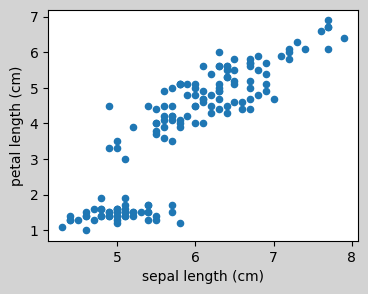

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "lightgrey"

bunch = load_iris()
df = pd.DataFrame(bunch['data'], columns=bunch['feature_names'])
X = df[['sepal length (cm)', 'petal length (cm)']].values
y = pd.DataFrame(bunch['target'])
df.plot.scatter(x='sepal length (cm)', y='petal length (cm)', figsize = (4,3))
plt.show()



In the unsupervised learning problem, we want to create a cluster label for each example in this plot. 

We use the K-Means clustering algorithm with  $K=2$ and $K=3$, where $K$ is the number of clusters, which is a hyperparameter. Later below, we  describe how the best value of $K$ that describes the data can be optimized.

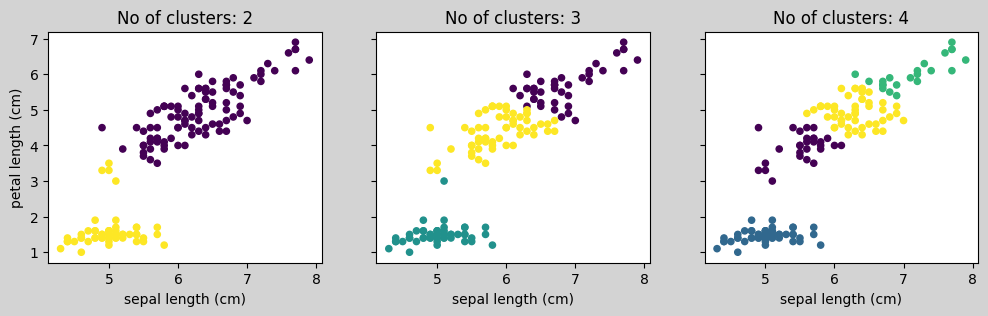

In [3]:
from sklearn.cluster import KMeans

def run_kmeans(n_clusters, ax):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto').fit(X)
    df.assign(predictions=kmeans.predict(X)).plot.scatter(
        ax = ax,
        x='sepal length (cm)', y='petal length (cm)', 
        c='predictions', 
        cmap=plt.cm.viridis, legend=False,
        colorbar = False,
        title = f"No of clusters: {n_clusters}")

fig, axes = plt.subplots(nrows=1, ncols=3, sharex = True, sharey=True, figsize = (12,3))

run_kmeans(2, ax = axes[0])
run_kmeans(3, ax = axes[1])
run_kmeans(4, ax = axes[2])


In the  the iris dataset, since we  have the actual example labels,  we can therefore see if our results for $K=3$  are consistent with the known number of clusters and label assignments.

Observe the mislabeled examples among the cluster outliers, and the hard clustering of the examples on the cluster boundaries.


Known Cluster Labels: ['setosa', 'versicolor', 'virginica']



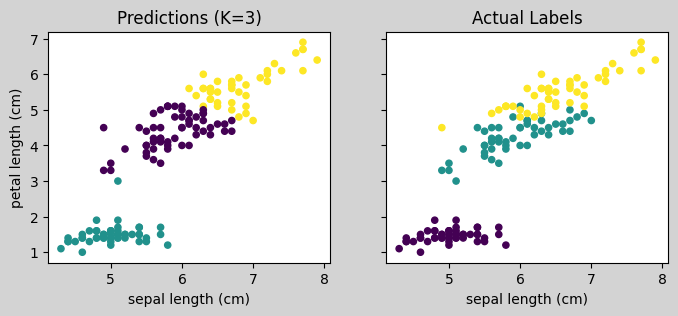

In [4]:
print(f"Known Cluster Labels: {bunch['target_names'].tolist()}\n")

fig, axes = plt.subplots(nrows=1, ncols=2, sharex = True, sharey=True, figsize = (8,3))

df.assign(predictions=KMeans(n_clusters=3, n_init='auto').fit(X).predict(X)).plot.scatter(
            ax=axes[0],
            x='sepal length (cm)', 
            y='petal length (cm)', 
            c='predictions', 
            cmap=plt.cm.viridis, colorbar = False,
            title = "Predictions (K=3)"
    )
                         
df.assign(labels=bunch['target']).plot.scatter(
            ax=axes[1],
            x='sepal length (cm)', 
            y='petal length (cm)', 
            c='labels', 
            cmap=plt.cm.viridis, colorbar = False,
            title = "Actual Labels"
    )

plt.show()

## Distance Metrics 

Clustering is based on grouping nearby examples using a distance metric $d(\mathbf{x}, \mathbf{y}) \in \mathbb{R}^n$ in the feature space.

For example, a popular distance metric is the  so-called Euclidean distance between 2 points in n-dimensional space.

$$d(\mathbf{x}, \mathbf{y}) = \left[\sum_{i=1}^n (x_i - y_i)^2 \right]^{1/2}$$

Clusters are obtained by  grouping sets of points which are close to each other in feature space using this distance metric  

**Question**: How important is it to rescale the features before using this algorithm?

## KMeans algorithm details

1. Start with an initial guess for the K cluster centers (the number K of cluster centers is kept fixed).
2. Assign each example to the cluster label for  the nearest  cluster center
3. Recompute the guess for the cluster centers as the mean of the examples assigned to each cluster label
4. Repeat Steps 2 and 3 until convergence (i.e., when the cluster labels for the examples  do not change)


The assumptions behind this algorithm are that the individual clusters are convex, and have isotropic shapes and variances. (These assumptions are reasonable if not much is known about the data, but can be removed with more advanced algorithms).

The initialization or cluster seeding of the K-means algorithm is very important, and there are many tricks used in practice.   These  include (a) random initialization, and (b) using some K randomly-selected actual examples as the cluster centers. 


## Curse of Dimensionality

The K-means algorithm runs into  computation difficulties in high feature dimensions (large $n$).

Our intuitions about distances, which are built around low dimensionality examples, often fails with examples in high dimensions.

For example, consider how the  distances $d_n$ between random points in a unit hypercube are distributed in high dimensions?  

A full discussion of this analysis is [provided here](https://math.stackexchange.com/questions/1976842/how-is-the-distance-of-two-random-points-in-a-unit-hypercube-distributed).

As can be seen below (for values of  $n > 3$), the distribution of $d_n/\sqrt{n}$ has a mean centered around $0.4$, and a variance that decreases for large $n$.

More precisely, for  large $n$, the distribution of $d_n$ has approximate mean  $\sqrt{ 𝑛/6−7/120}$ and 
 and approximate variance of $7/120$.

The upshot of this analysis is that any two random points in the unit hypercube will roughly be equidistant from each other and the distance function therefore loses its effectivenes for identifying clusters in higher dimensions. 



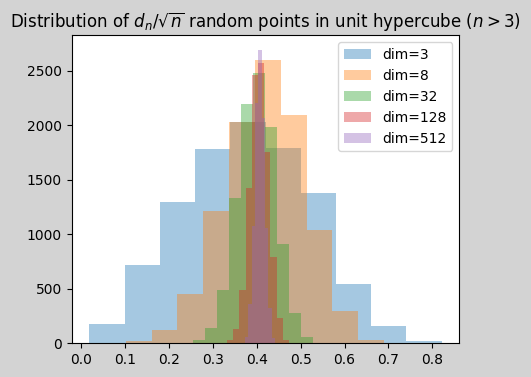

In [9]:
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt


res = []
dims = [3, 8, 32, 128, 512]
for N in dims:
    sample = np.random.uniform(size=(100, N))
    distances = [np.linalg.norm(a - b) for a, b in permutations(sample, 2)]
    res.append(distances)

plt.figure(figsize=(5,4))
for i, r in zip(dims, res):
    plt.hist(r / np.sqrt(i), alpha=.4, label=f'dim={i}')

plt.legend()
plt.title(r'Distribution of $d_n/\sqrt{n}$ for random points in unit hypercube $(n>3)$')
plt.show()

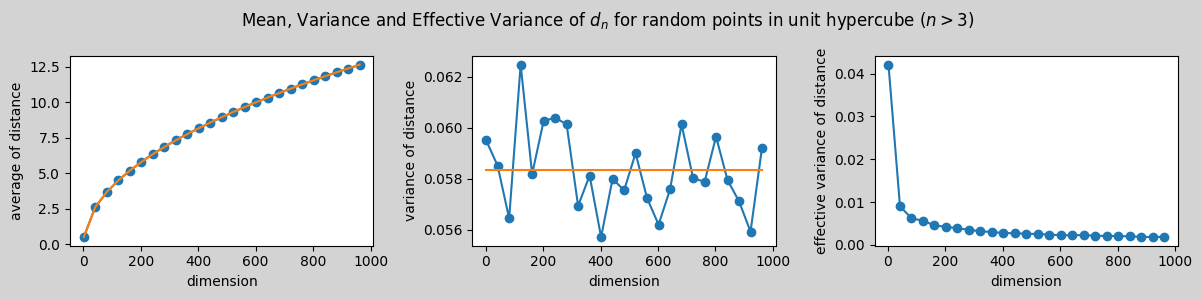

In [11]:
res = []
dims = np.arange(2, 1000, 40)
for N in dims:
    sample = np.random.uniform(size=(200, N))
    distances = [np.sqrt(np.sum((a - b)**2)) for a, b in permutations(sample, 2)]
    res.append(distances)

fig, ax = plt.subplots(nrows=1, ncols=3, sharex = True, figsize = (12,3))

ax[0].plot(dims, [np.mean(i) for i in res], 'o-')
ax[0].plot(dims, np.sqrt(dims/ 6 - 7/120))
ax[0].set_xlabel('dimension')
ax[0].set_ylabel('average of distance')

ax[1].plot(dims, [np.var(i) for i in res], 'o-')
ax[1].plot(dims, [7/120 for _ in dims])
ax[1].set_xlabel('dimension')
ax[1].set_ylabel('variance of distance')


ax[2].plot(dims, [np.var(i)/ np.sqrt(d) for i, d in zip(res, dims)], 'o-')
ax[2].set_xlabel('dimension')
ax[2].set_ylabel('effective variance of distance')

plt.suptitle(r'Mean, Variance and Effective Variance of $d_n$ for random points in unit hypercube $(n>3)$')
plt.tight_layout()
plt.show()

# Underfitting and Overfitting


In the context of $K$-Means, underfitting is equivalent to having too few clusters, and overfitting is equivalent to having too many clusters.    

The examples below show a range of $K$ values.   The case when $K=2$ clusters is underfitting since  since the two cluster fail to capture the true structure of the data in its entirety.

If we further increase the number of clusters, at the other extreme $K 20$ clusters is overfitting since this results in  small, local clusters which do not capture the true structure of the data.

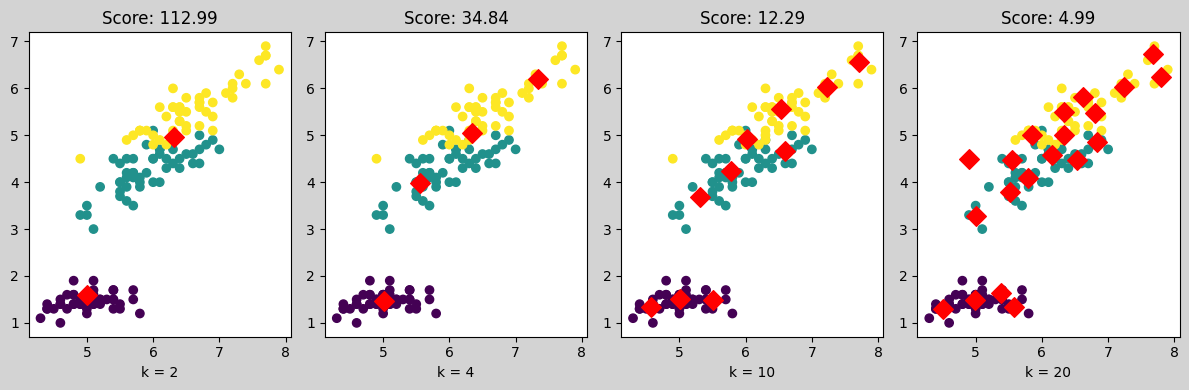

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "lightgrey"

from sklearn.datasets import load_iris
from sklearn import cluster

bunch = load_iris()
df = pd.DataFrame(bunch['data'], columns=bunch['feature_names'])
X = df[['sepal length (cm)', 'petal length (cm)']].values
y = pd.DataFrame(bunch['target'])

Ks = [2, 4, 10, 20]

f, axes = plt.subplots(1,len(Ks), figsize = (12,4))
for k, ax in zip(Ks, axes):
    model = cluster.KMeans(n_clusters=k, n_init='auto')
    model.fit(X)
    ax.scatter(X[:,0], X[:,1], c=y)
    ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='D', c='r', s=100)
    ax.set_title('Score: %.2f' % -model.score(X))
    ax.set_xlabel(f"k = {k}")

plt.tight_layout()
plt.show()

# Finding the right number of Clusters

There are a number of good methods for determing the best value of $K$.  

Consider the following example, where the true value of $K = 4 $ is known, and where the true individual clusters are also such that the K-means algorithm can be expected to recover the true cluster if $K$ is correctly specified. 

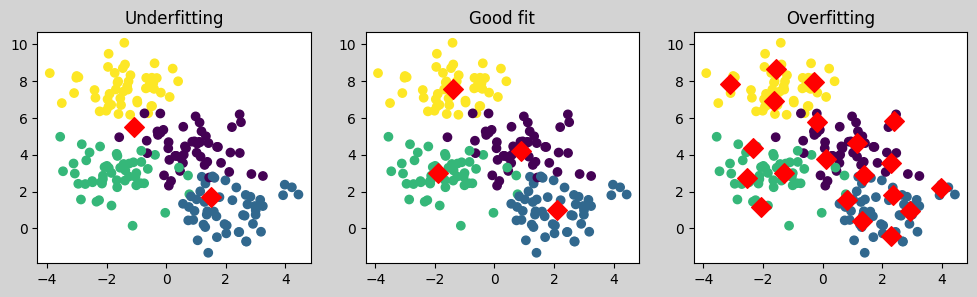

In [8]:
from sklearn import datasets
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=200, centers=4)

Ks, titles = [2, 4, 20], ['Underfitting', 'Good fit', 'Overfitting']
f, axes = plt.subplots(1,3, figsize=(12,3))
for k, title, ax in zip(Ks, titles, axes):
    model = cluster.KMeans(n_clusters=k,n_init='auto')
    model.fit(X)
    ax.scatter(X[:,0], X[:,1], c=y)
    ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='D', c='r', s=100)
    ax.set_title(title)

plt.show()

## The Elbow Method

We now consider an approach to identify the best possible value of $K$ which is in fact a more general method for tuning hyper-parameters in unsupervised learning.
* We plot the objective function (model score) as a function of the hyper-parameter.
* The "elbow" is when this   curve occurs when this curve begins to level off.
* The corresponding value on the x-axis is a good value for the hyperparameter.

In our example, the model score has an elbow at about $K=4$, and after which the plot levels off substantially. This value also recovers the known true value.

Text(0, 0.5, 'Objective Function Value')

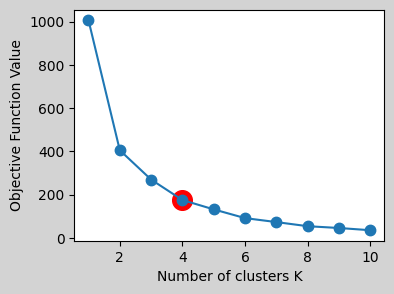

In [27]:
Ks, objs = range(1,11), []
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init='auto')
    model.fit(X)
    objs.append(-model.score(X))

plt.figure(figsize=(4,3))
plt.plot(Ks, objs, '.-', markersize=15)
plt.scatter([4], [objs[3]], s=200, c='r')
plt.xlabel("Number of clusters K")
plt.ylabel("Objective Function Value")

## Unsupervised Learning Metrics

Unsupervised learning has several metrics, and the choice of metrics depends on the nature of the application.

We will go over two common metrics here to illustrate their  advantages and disadvantages in practice.

Some clustering metrics require knowledge of the "ground truth classes", but this information is rarely available in the typical unsupervised learning applications.  

### Inertia
The most basic one is called the inertia.  Given clusters $C_j$ with  means $\mu_j$, this metric is given as 

$$ \sum_i \min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

This is effectively the same metric that is minimized by the K-means algorithm and reported as the model score. 

As noted earlier, this metric is less effective in high-dimensions due to it's inability to distinguish between different cluster configurations.


In [28]:
kmeans = KMeans(n_clusters=3,n_init='auto').fit(df.values)
kmeans.inertia_

78.85566582597731

### Silhouette Coefficient

The Silhouette coefficient measures how well defined the clusters are in relation to each other.

For each sample, we define

$a$ - mean distance between sample and all other points of same class

$b$ - mean distance between sample and all points in nearest cluster (not same class)

$$ s = \frac{b - a}{max(a, b)}$$

The full metric is the mean  of $s$ over the whole data set.

Lets look at the different types of values

- $a \ll b$, $s \to 1$.  This is good!
- $a \approx b$ $s \to 0$.  The cluster not well defined
- $a \gg b$ $s \to -1$. The differing clusters are quite similar

In [29]:
from sklearn.metrics import silhouette_score
silhouette_score(df.values, kmeans.predict(df.values))

0.551191604619592

## Other Clustering Algorithms

There are many other clustering algorithms that address some of the issues with the basic $K$-means algorithm. 

For example, if you want to perform clustering on non-convex datasets, you might want to use something like `DBSCAN`.  We can compare the performance of K-means and DBSCAN on a dataset of non-convex clusters.

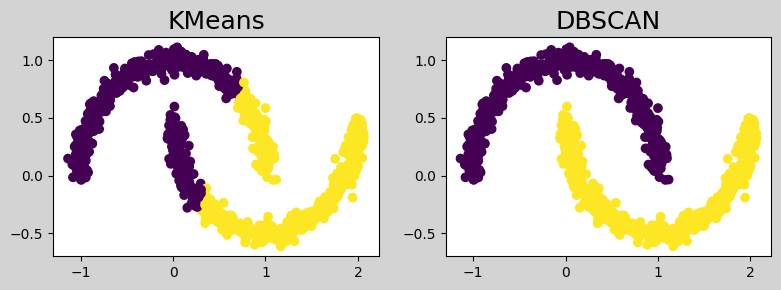

In [30]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05)

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, (algo, params) in enumerate([
    (KMeans, dict(n_clusters=2, n_init='auto')),
    (DBSCAN, dict(eps=.15)),
]):
    model = algo(**params).fit(X)
    ax[i].scatter(*X.T, c=model.labels_)
    ax[i].set_title(algo.__name__, fontsize = 18)
plt.tight_layout()

# Dimensionality Reduction

Unsupervised learning can be used as a precursor to supervised learning.  One common use case is the need to reduce the number of dimensions in the feature matrix used for supervised learning.

A smaller feature set can lead to better generalization performance, reduce overfitting, and avoid the computational issues that arise from the presence of highly correlated features.



## Principal Component Analysis

The idea is often used to find a  smaller dimensional space which best approximates the higher dimensional space spanned by a matrix.

In order to do this, we linearly project vectors on to a lower-dimensional subspace which captures the largest variations in the data. 

PCA is often implemented in scikit-learn as a `Transformer` because its so often used at the beginning of a set of transformations to reduce the input feature dimension and to remove correlated input features. 

PCA is illustrated here using an example in 2 dimensions. 

We can look at the components, which tells us what linear combination of feature vectors are contained in each of the components.

Typically we also want to look at how much of the variance is explained, we can use the total amount `explained_variance_`, or the relative amount `explained_variance_ratio_`.

We can also plot the principal components along with the data. 


Results of the Principal Component Analysis
The principal components are given by: 
 [[ 0.88159892  0.47199931]
 [-0.47199931  0.88159892]]
The explained variance of the principal components is given by: 
 [4.00437998 0.49279034]
The explained variance ratio of the principal components is given by: 
 [0.89042213 0.10957787]




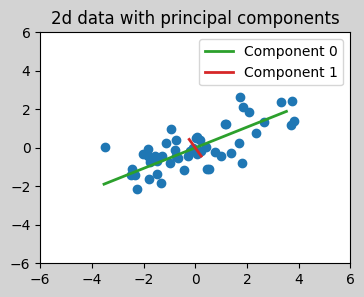

In [74]:
# create a 2-d data set with some correlated features 
import math

import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
scale1, scale2 = 2, 1
vals = rng.normal(scale=(scale1, scale2), size=(50, 2))
theta = -35
vals[:, 0] = vals[:, 0] * np.cos(theta) - vals[:, 1] * np.sin(theta)
vals[:, 1] = vals[:, 1] * np.cos(theta) + vals[:, 0] * np.sin(theta)

# normalize columns by subtracting the column mean
vals = vals - np.mean(vals, axis = 0)

# plot the data
plt.figure(figsize = (4,3))
plt.scatter(vals[:,0], vals[:,1])
N = 3*math.ceil(max(scale1,scale2))
plt.xlim(-N, N)
plt.ylim(-N, N)

# obtain the first principa component and plot it
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(vals)

print(f"\nResults of the Principal Component Analysis")
print(f"The principal components are given by: \n {pca.components_}")

print(f"The explained variance of the principal components is given by: \n {pca.explained_variance_}")

print(f"The explained variance ratio of the principal components is given by: \n {pca.explained_variance_ratio_}\n\n")

# plot the data and the principal components
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [-comp[0], comp[0]],
        [-comp[1], comp[1]],
        label=f"Component {i}",
        linewidth=2,
        color=f"C{i + 2}",
    )
plt.legend()
plt.title("2d data with principal components")
plt.show()

## Principal Components in ML pipeline

Lets create a very simple pipeline which uses  PCA of the input features.

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('model', LinearRegression())
])

Lets consider the use of a PCA preprocessing component in the  original iris problem and see what happens when we project this data into two dimensions (as opposed to the original 4 features)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


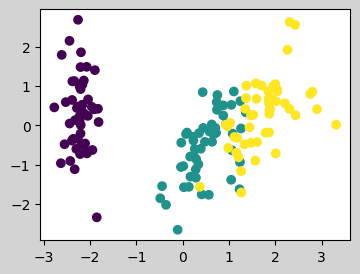

In [77]:
from sklearn.preprocessing import scale
from sklearn import datasets
import pandas as pd
bunch = datasets.load_iris()
df = pd.DataFrame(bunch['data'], columns=bunch['feature_names'])
iris_pca = PCA(n_components=2).fit(scale(df.values))
plt.figure(figsize=(4,3))
plt.scatter(
    *iris_pca.transform(scale(df.values)).T,
    c=bunch['target']
)
df.head()

We can look at how these features are represented by breaking down the components for each vector of the PCA.

[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]


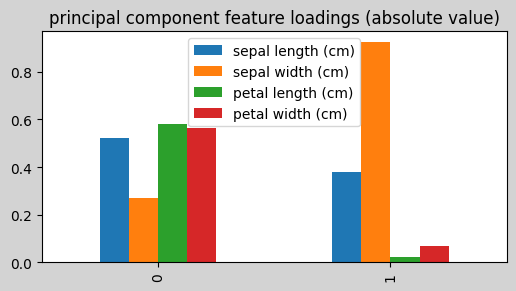

In [79]:
pd.DataFrame(iris_pca.components_, columns=df.columns).abs().plot.bar(
    figsize=(6,3),
    title='principal component feature loadings (absolute value)'
)
print(iris_pca.components_)

### PCA - the math

The PCA for $k$ components is just the  computation of the first $k$ eigenvalues and eigenvectors of the covariance matrix $X^TX$, which corresponding the each principal component and the corresponding explained variance for that eigenvector.

Brief eigen-decomposition review

$$Av = \lambda v$$
$A$ is a symmetric positive-definite matrix, $\lambda$ is eignevalue, $v$ is eigenvector.

Intitution is that if $A$ is a linear transformation, then $v$ correspond to vectors whose directions are unchanged under the transformation by $A$ (they are just scaled by $\lambda$.)

## Scree plots

There is no "one true way" of finding the proper number of components in PCA for dimensionality reduction, but there are a few methods.

The Scree method is similar to the  "elbow method" used earlier in clustering. 

We look at the eigenvalues (equivalently, the explained variance) ordered by decreasing magnitude and look for the "elbow" in the plot  to  identify the right number of components for PCA reduction.

Similarly, one can also  look at the cumulative explained variance to see the number of components that are sufficient to obtain a good PCA reduction.

Fraction of explained variance in PCA reduction:
[0.25336868 0.48853113 0.64741747 0.77629718 0.90167913]



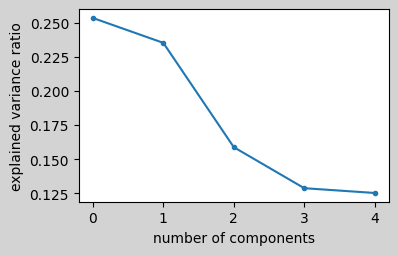

In [85]:
from sklearn.datasets import fetch_california_housing
bunch = fetch_california_housing()


from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=5).fit(StandardScaler().fit_transform(bunch['data']))
# cumulative proportaional variance
print(f"Fraction of explained variance in PCA reduction:\n{np.cumsum(pca.explained_variance_ratio_)}\n")

fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(pca.explained_variance_ratio_, '.-')
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio")
plt.show()

Fraction of explained variance in PCA reduction:
[0.25336868 0.48853113 0.64741747 0.77629718 0.90167913]


## EigenFaces

In [26]:
from sklearn.datasets import fetch_olivetti_faces
bunch = fetch_olivetti_faces()

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(
    bunch['data'][67].reshape(64, 64), plt.cm.gray
)
plt.tight_layout()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/jupyter-ramesh/scikit_learn_data


We can create a PCA over faces data to learn the principle components of a face.  Lets take a much smaller number of components

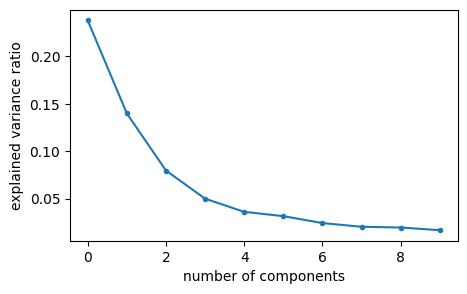

In [52]:
n_components = 10
faces_pca = PCA(n_components=n_components, svd_solver='randomized').fit(bunch['data'])

fig, ax = plt.subplots(figsize=(5,3))

ax.plot(faces_pca.explained_variance_ratio_, '.-')
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio")
plt.show()

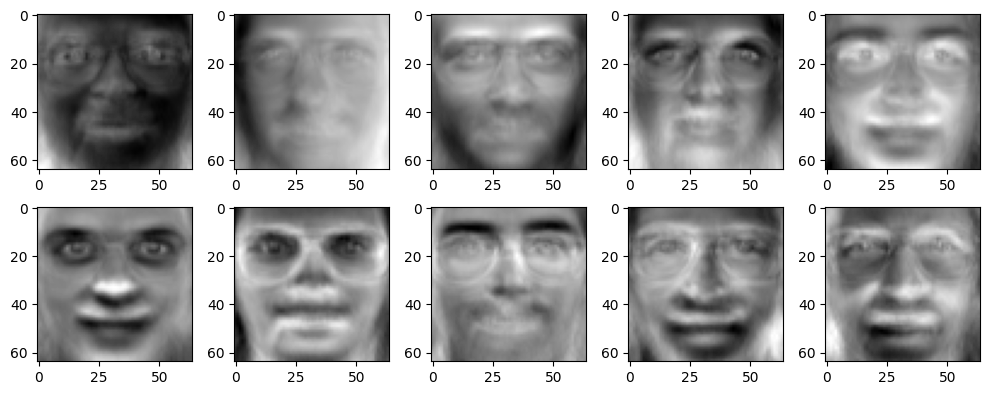

In [35]:
n_rows = int(np.ceil(n_components / 5))
fig, ax = plt.subplots(n_rows, 5, figsize=(10, 4))
for component, ax_ in zip(faces_pca.components_, ax.ravel()):
    ax_.imshow(component.reshape(64, 64), plt.cm.gray)
plt.tight_layout()

# Futher Topics

- Latent Semantic Analysis (LSA) in Text Modeling
- Latent Dirichlet Allocation in Topic Modeling (Generative Model)
- Non-Negative Matrix Factorization in Recommendation Systems